In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Stock Universe and Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('auto.csv', index_col=['date'])
prices.head(10)

MARUTI.NS  TATAMOTORS.NS      M&M.NS  BAJAJ-AUTO.NS  \
date                                                                
01-01-2018  9651.900391     424.450012  744.650024    3289.250000   
02-01-2018  9554.049805     439.299988  752.900024    3294.750000   
03-01-2018  9416.599609     433.899994  754.900024    3241.050049   
04-01-2018  9386.250000     429.950012  756.000000    3264.449951   
05-01-2018  9433.849609     431.600006  756.349976    3279.850098   
08-01-2018  9448.950195     433.549988  759.900024    3275.750000   
09-01-2018  9383.549805     437.549988  762.450012    3243.500000   
10-01-2018  9375.849609     433.299988  759.849976    3207.399902   
11-01-2018  9339.799805     434.750000  766.650024    3193.399902   
12-01-2018  9459.150391     437.100006  767.500000    3175.350098   

            EICHERMOT.NS  HEROMOTOCO.NS  BALKRISIND.NS  BHARATFORG.NS  \
date                                                                    
01-01-2018   2989.314941    3749.100098    1195.449951     723.000000   
02-01-2018   2867.014893    3743.850098    1173.250000     728.049988   
03-01-2018   2881.435059    3755.199951    1189.050049     733.099976   
04-01-2018   2857.074951    3738.899902    1205.300049     726.950012   
05-01-2018   2923.699951    3744.649902    1210.699951     738.849976   
08-01-2018   2919.739990    3786.750000    1202.800049     742.400024   
09-01-2018   2859.695068    3749.449951    1176.550049     732.599976   
10-01-2018   2809.750000    3736.899902    1166.449951     726.549988   
11-01-2018   2844.469971    3705.649902    1157.849976     727.450012   
12-01-2018   2864.975098    3687.350098    1158.500000     730.599976   

            ASHOKLEY.NS  TIINDIA.NS  
date                                 
01-01-2018   118.650002  269.799988  
02-01-2018   123.349998  268.149994  
03-01-2018   124.500000  273.850006  
04-01-2018   126.949997  280.600006  
05-01-2018   127.449997  294.450012  
08-01-2018   128.449997  294.700012  
09-01-2018   130.500000  295.600006  
10-01-2018   127.949997  294.100006  
11-01-2018   127.050003  287.399994  
12-01-2018   128.649994  287.350006

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

MARUTI.NS  TATAMOTORS.NS      M&M.NS  BAJAJ-AUTO.NS  \
date                                                                
01-01-2018  9651.900391     424.450012  744.650024    3289.250000   
02-01-2018  9554.049805     439.299988  752.900024    3294.750000   
30-12-2020  7612.899902     184.149994  720.700012    3448.149902   
31-12-2020  7649.600098     183.850006  720.599976    3444.050049   

            EICHERMOT.NS  HEROMOTOCO.NS  BALKRISIND.NS  BHARATFORG.NS  \
date                                                                    
01-01-2018   2989.314941    3749.100098    1195.449951     723.000000   
02-01-2018   2867.014893    3743.850098    1173.250000     728.049988   
30-12-2020   2517.350098    3101.399902    1615.050049     517.599976   
31-12-2020   2530.899902    3110.000000    1646.300049     525.299988   

            ASHOKLEY.NS  TIINDIA.NS  
date                                 
01-01-2018   118.650002  269.799988  
02-01-2018   123.349998  268.149994  
30-12-2020    94.800003  793.299988  
31-12-2020    95.449997  800.849976

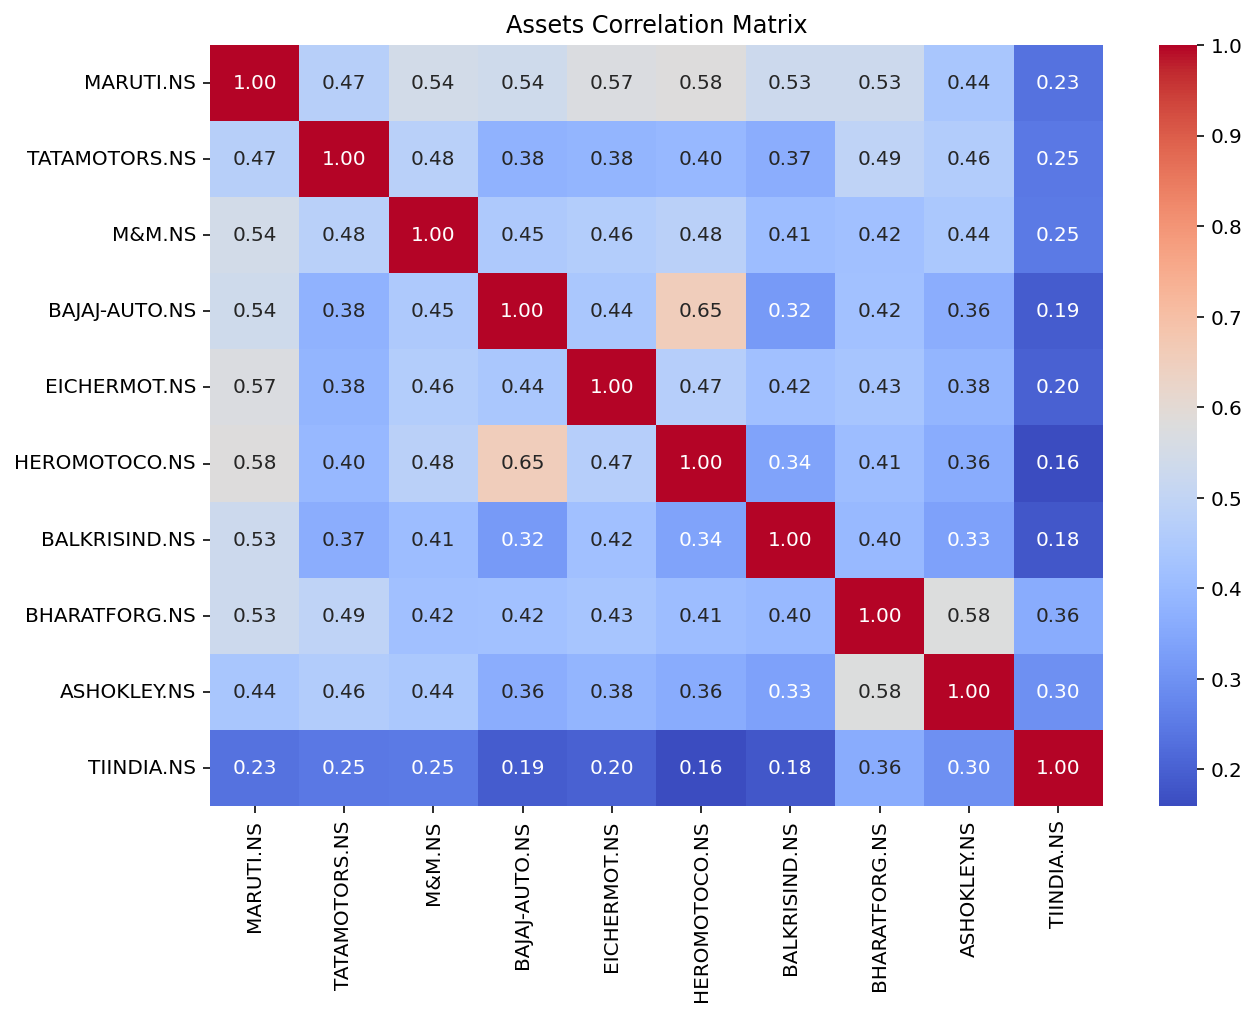

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('MARUTI.NS', 'EICHERMOT.NS'), ('MARUTI.NS', 'BHARATFORG.NS'), ('MARUTI.NS', 'ASHOKLEY.NS'), ('TATAMOTORS.NS', 'M&M.NS'), ('TATAMOTORS.NS', 'BHARATFORG.NS'), ('TATAMOTORS.NS', 'ASHOKLEY.NS'), ('EICHERMOT.NS', 'HEROMOTOCO.NS'), ('EICHERMOT.NS', 'BHARATFORG.NS'), ('EICHERMOT.NS', 'ASHOKLEY.NS'), ('BHARATFORG.NS', 'ASHOKLEY.NS')]


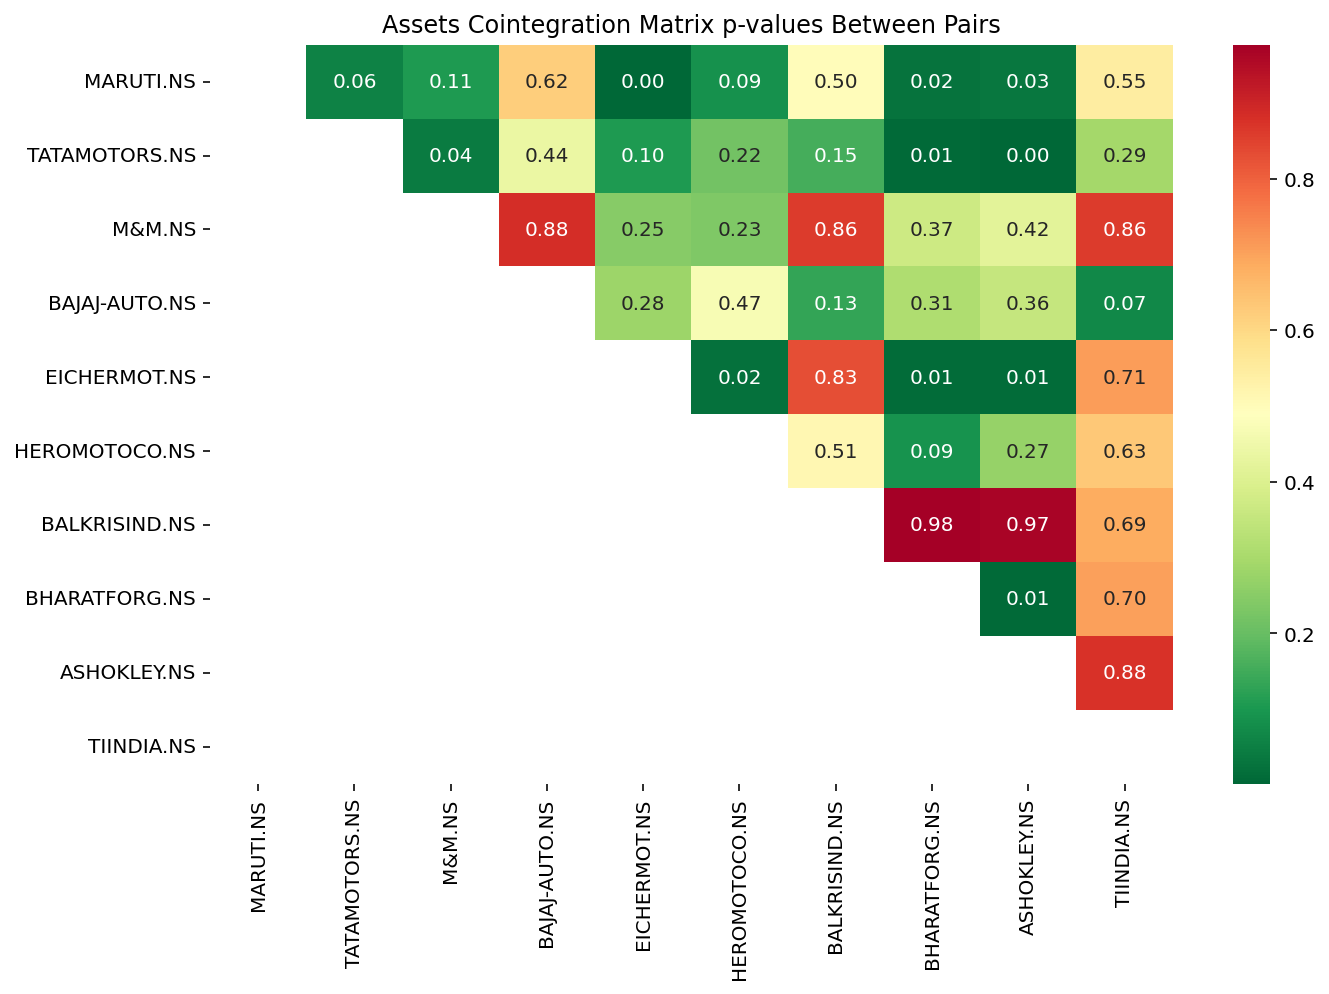

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'MARUTI.NS'
asset2 = 'BHARATFORG.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          6.626e+04
Date:                Tue, 22 Mar 2022   Prob (F-statistic):                        0.00
Time:                        12:23:03   Log-Likelihood:                         -4020.0
No. Observations:                 740   AIC:                                      8042.
Df Residuals:                     739   BIC:                                      8047.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.0714      0.000    257.406      0.000       0.071       0.072
==============================================================================
Omnibus:                       49.759   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.705
Skew:                           0.689   Prob(JB):                     1.79e-13
Kurtosis:                       3.063   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

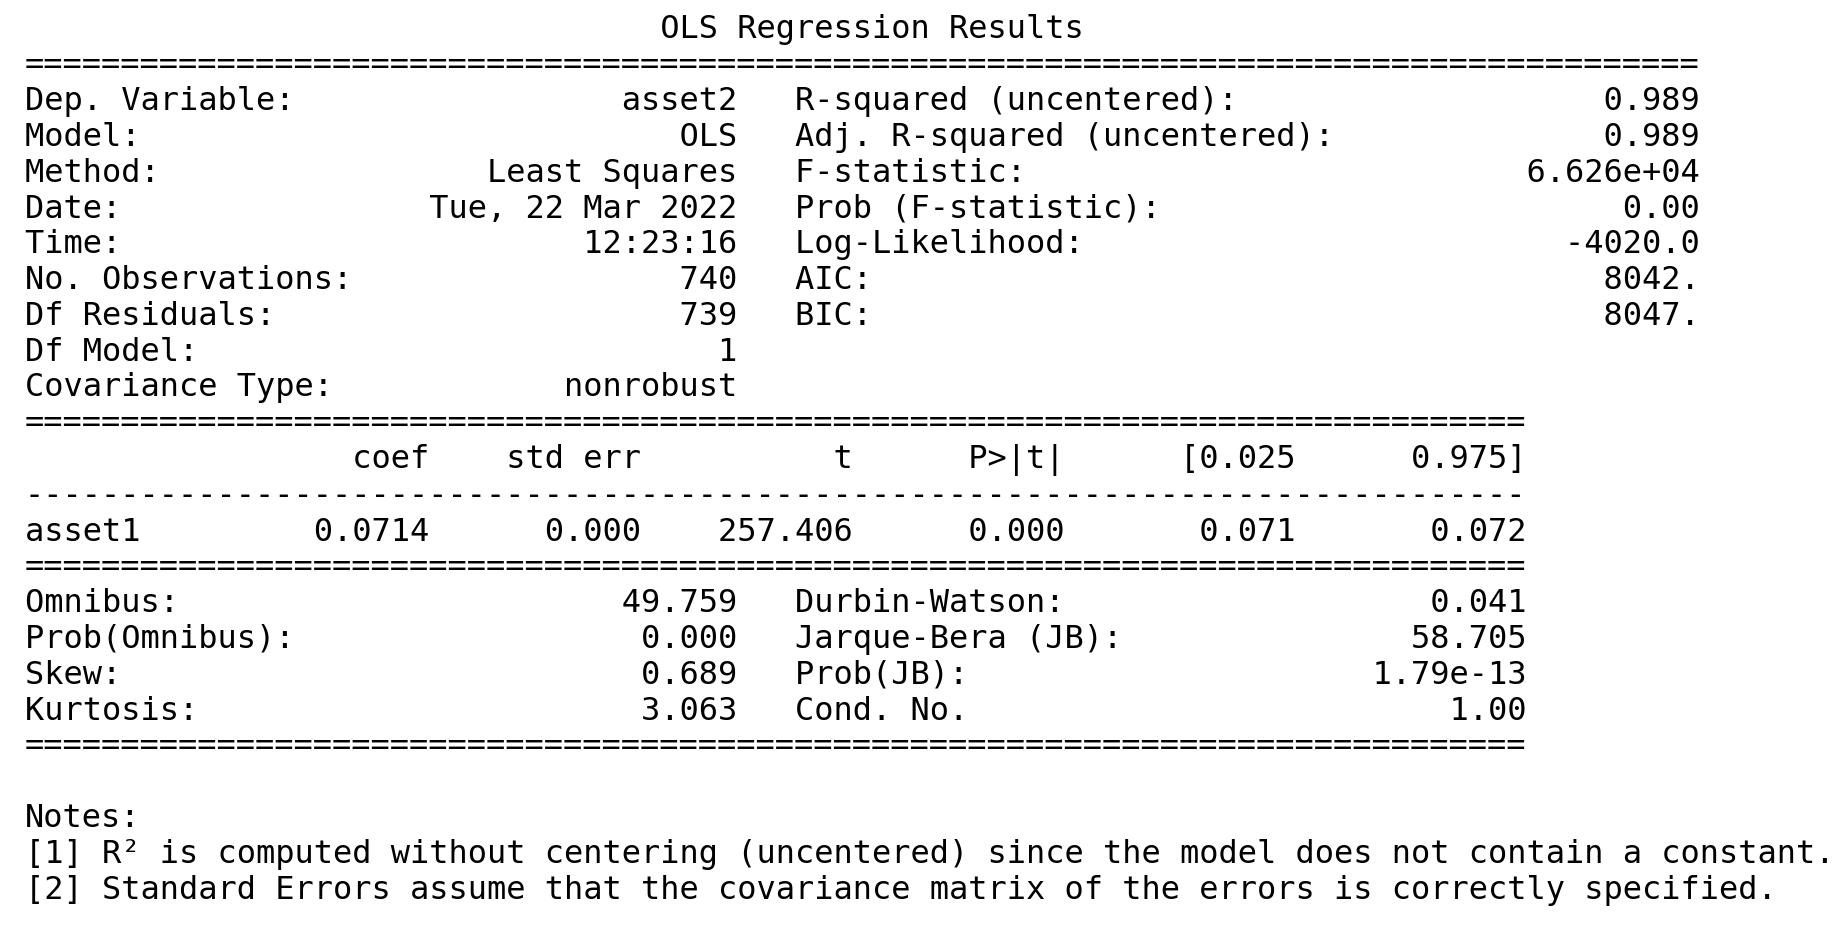

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.07137067313142575


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

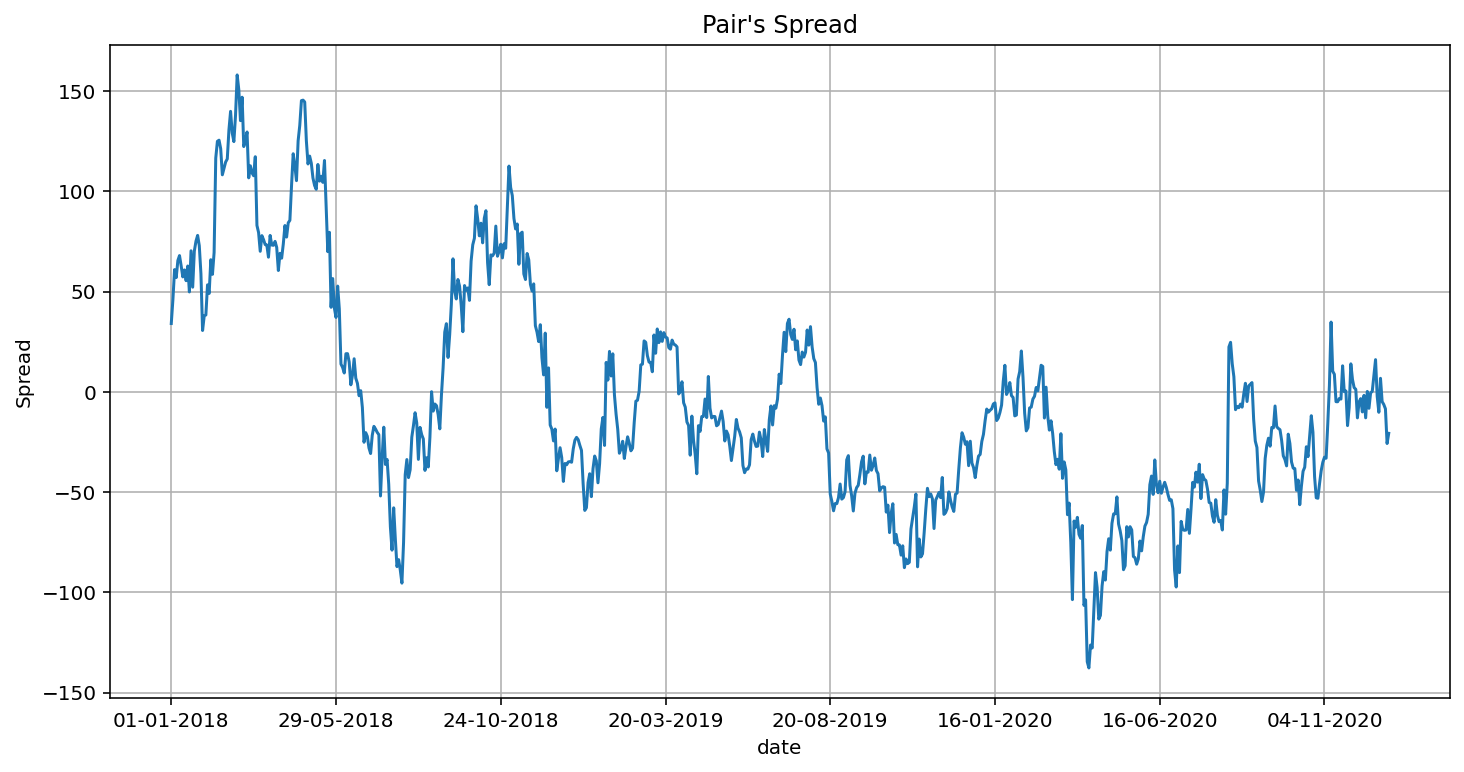

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.5385316225727594,
 0.10637836600221567,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 5651.912220753577)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.5385316225727594


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                               
01-01-2021  7691.299805  538.099976
04-01-2021  7702.299805  552.599976
05-01-2021  7655.450195  556.549988
06-01-2021  7628.600098  548.299988
07-01-2021  7566.049805  598.849976

In [23]:
signals.tail()

asset1      asset2
date                               
27-12-2021  7289.500000  687.000000
28-12-2021  7297.450195  702.049988
29-12-2021  7350.049805  701.750000
30-12-2021  7282.250000  693.900024
31-12-2021  7426.450195  697.849976

In [24]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [25]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  7691.299805  538.099976  3.021188            1.0           -1.0
04-01-2021  7702.299805  552.599976  2.742414            1.0           -1.0
05-01-2021  7655.450195  556.549988  2.598687            1.0           -1.0
06-01-2021  7628.600098  548.299988  2.722707            1.0           -1.0
07-01-2021  7566.049805  598.849976  1.718844            1.0           -1.0

In [26]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [27]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

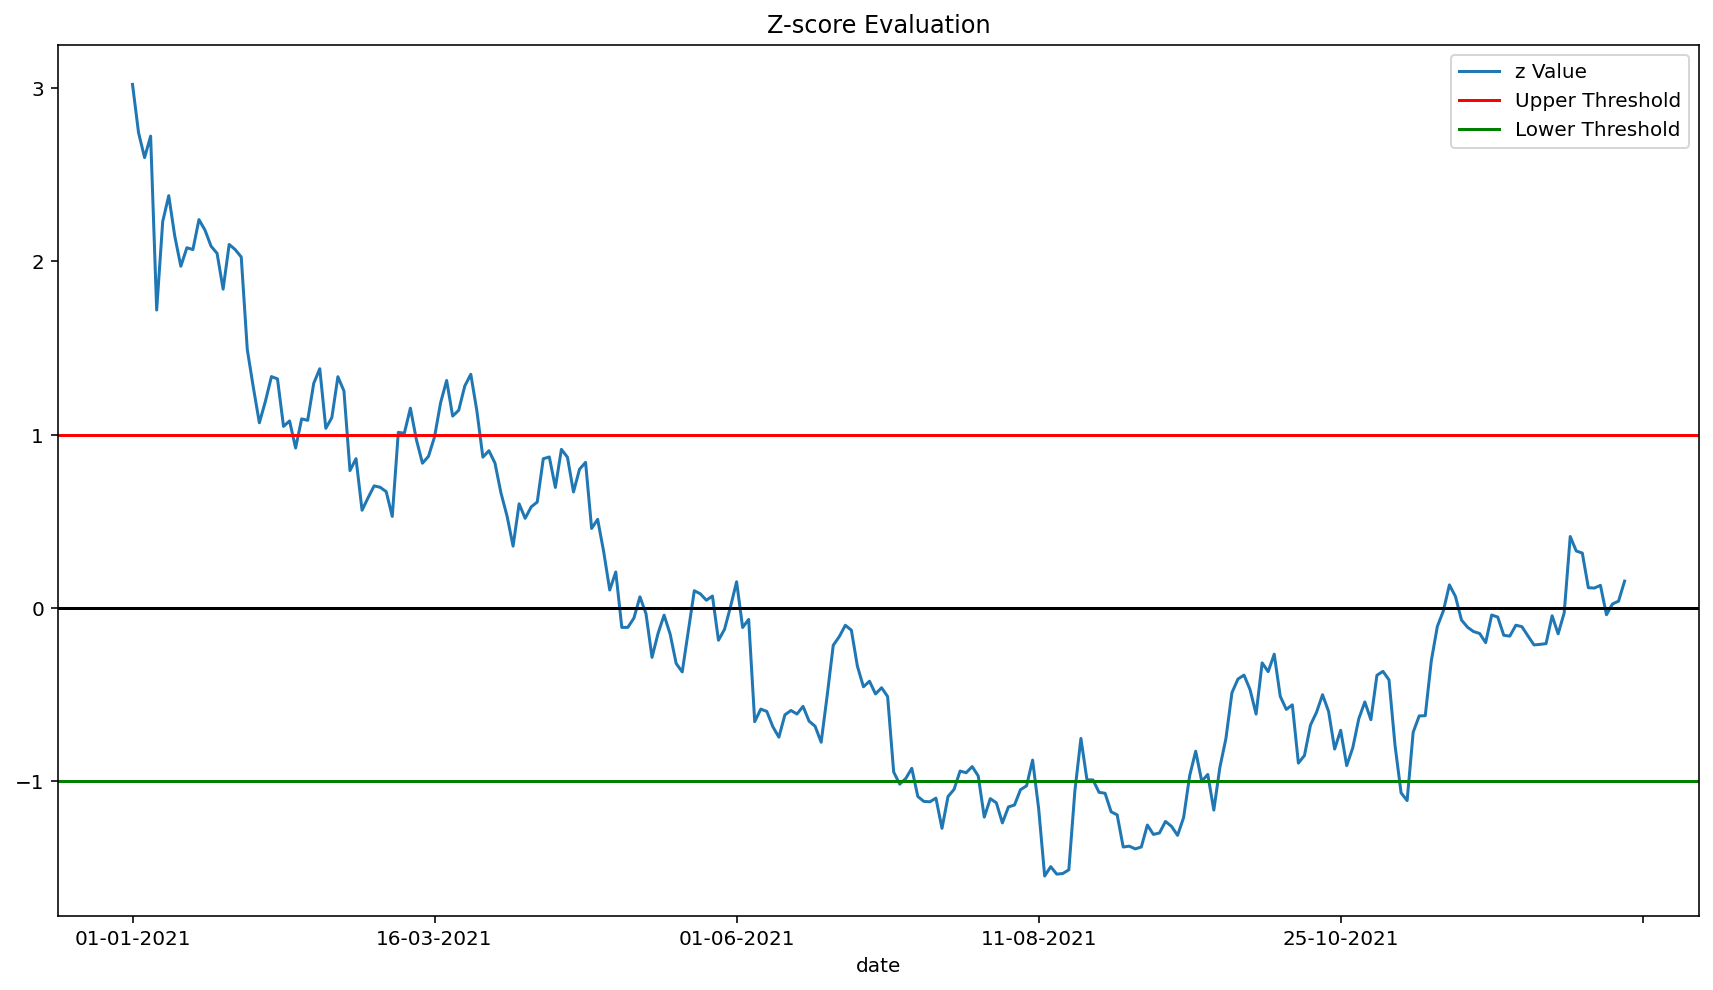

In [28]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [29]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  7691.299805  538.099976  3.021188            1.0           -1.0   
04-01-2021  7702.299805  552.599976  2.742414            1.0           -1.0   
05-01-2021  7655.450195  556.549988  2.598687            1.0           -1.0   
29-12-2021  7350.049805  701.750000  0.023026            1.0           -1.0   
30-12-2021  7282.250000  693.900024  0.039338            1.0           -1.0   
31-12-2021  7426.450195  697.849976  0.154909            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [30]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  7691.299805  538.099976  3.021188            1.0           -1.0   
04-01-2021  7702.299805  552.599976  2.742414            1.0           -1.0   
05-01-2021  7655.450195  556.549988  2.598687            1.0           -1.0   
06-01-2021  7628.600098  548.299988  2.722707            1.0           -1.0   
07-01-2021  7566.049805  598.849976  1.718844            1.0           -1.0   
08-01-2021  8014.899902  603.299988  2.229689            1.0           -1.0   
11-01-2021  8232.750000  610.950012  2.379008            1.0           -1.0   
12-01-2021  8188.049805  621.400024  2.144662            1.0           -1.0   
13-01-2021  8139.850098  628.250000  1.971667            1.0           -1.0   
14-01-2021  8149.450195  622.450012  2.078538            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
08-01-2021        -1         0.0         1         0.0  
11-01-2021        -1         0.0         1         0.0  
12-01-2021        -1         0.0         1         0.0  
13-01-2021        -1         0.0         1         0.0  
14-01-2021        -1         0.0         1         0.0

In [31]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  7691.299805  538.099976  3.021188            1.0           -1.0   
10-02-2021  7621.700195  655.900024  0.922839            1.0           -1.0   
11-02-2021  7667.350098  647.900024  1.090771            1.0           -1.0   
23-02-2021  6970.500000  608.549988  0.792584            1.0           -1.0   
05-03-2021  7249.000000  617.700012  1.013307            1.0           -1.0   
22-09-2021  6831.000000  740.849976 -0.960828            1.0           -1.0   
23-09-2021  6846.700195  764.299988 -1.166766            1.0           -1.0   
24-09-2021  6952.250000  749.799988 -0.920286            1.0           -1.0   
09-11-2021  7577.549805  834.049988 -1.066987            1.0           -1.0   
11-11-2021  7453.450195  782.049988 -0.717362            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
10-02-2021         0         1.0         0        -1.0  
11-02-2021        -1        -1.0         1         1.0  
23-02-2021         0         1.0         0        -1.0  
05-03-2021        -1        -1.0         1         1.0  
22-09-2021         0        -1.0         0         1.0  
23-09-2021         1         1.0        -1        -1.0  
24-09-2021         0        -1.0         0         1.0  
09-11-2021         1         1.0        -1        -1.0  
11-11-2021         0        -1.0         0         1.0

In [32]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

7621.700195    1
6970.500000    1
7272.100098    1
6784.450195    1
7401.200195    1
7430.350098    1
6993.500000    1
7021.500000    1
6608.600098    1
6777.000000    1
6846.700195    1
7577.549805    1
Name: asset1, dtype: int64

In [33]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  7691.299805  538.099976  3.021188            1.0           -1.0   
04-01-2021  7702.299805  552.599976  2.742414            1.0           -1.0   
05-01-2021  7655.450195  556.549988  2.598687            1.0           -1.0   
06-01-2021  7628.600098  548.299988  2.722707            1.0           -1.0   
07-01-2021  7566.049805  598.849976  1.718844            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  7289.500000  687.000000  0.130360            1.0           -1.0   
28-12-2021  7297.450195  702.049988 -0.039298            1.0           -1.0   
29-12-2021  7350.049805  701.750000  0.023026            1.0           -1.0   
30-12-2021  7282.250000  693.900024  0.039338            1.0           -1.0   
31-12-2021  7426.450195  697.849976  0.154909            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [34]:
signals = signals.reset_index()

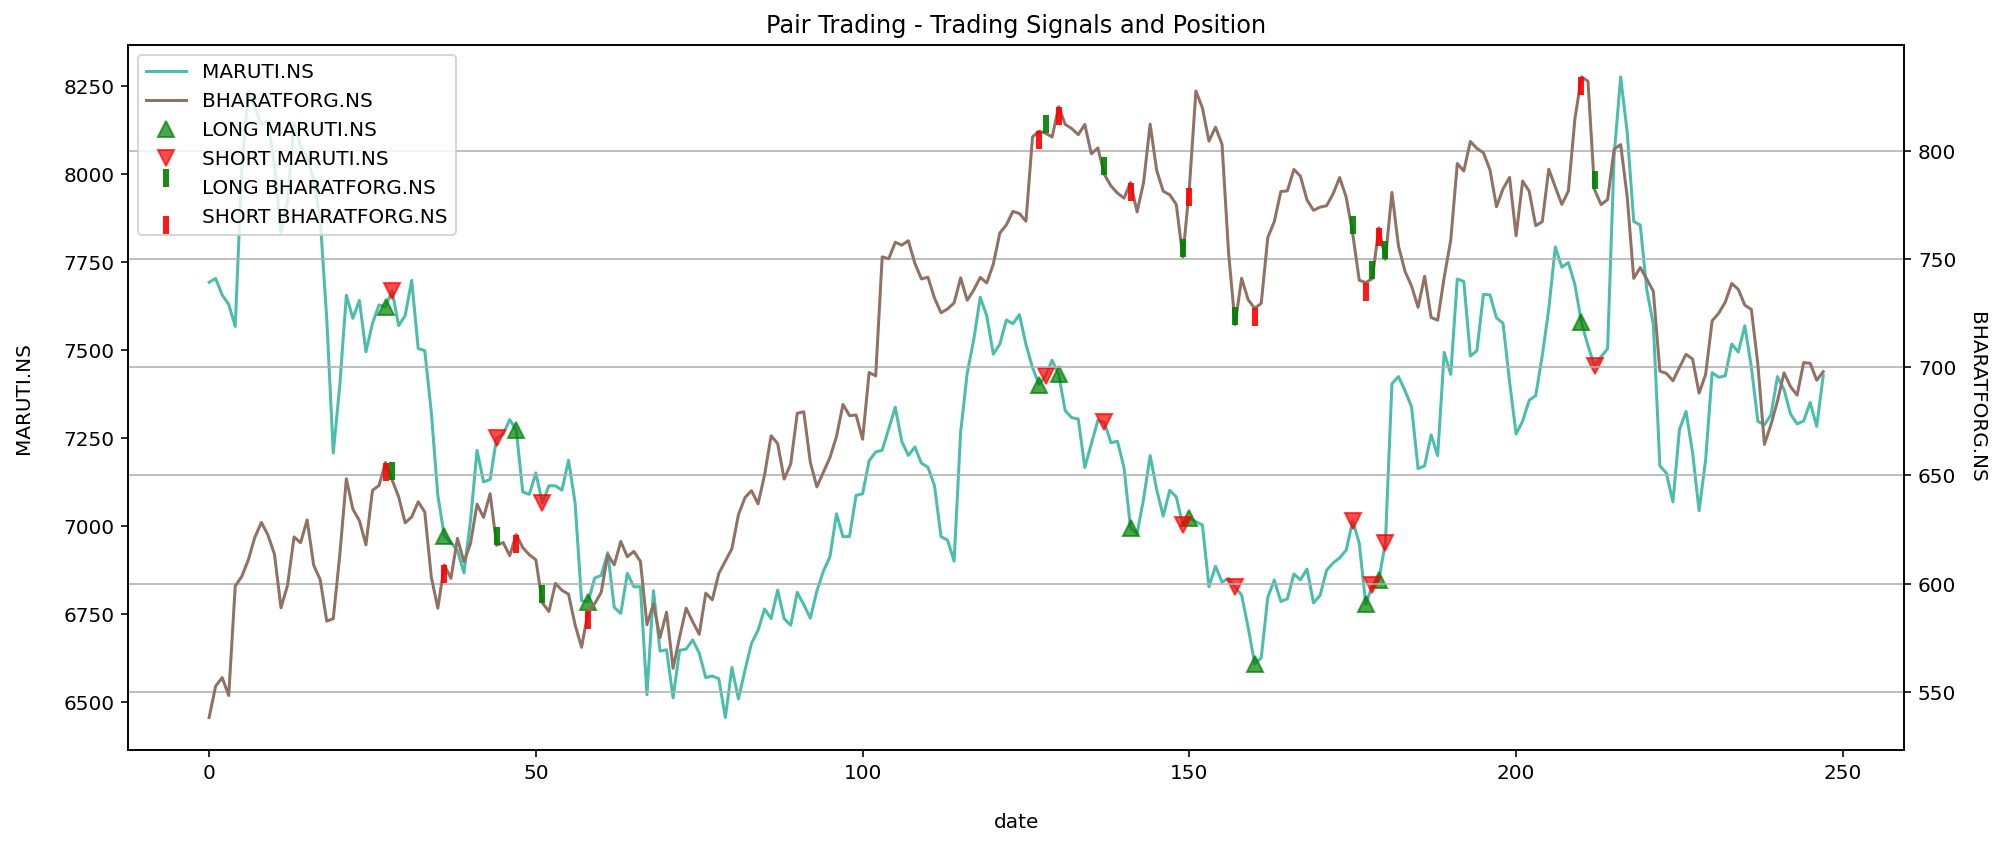

In [35]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [36]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [37]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [38]:
portfolio.head().append(portfolio.tail())

asset1    holdings1          cash1   total asset1   return1  \
0    7691.299805          NaN            NaN            NaN       NaN   
1    7702.299805      0.00000  100000.000000  100000.000000       NaN   
2    7655.450195      0.00000  100000.000000  100000.000000  0.000000   
3    7628.600098      0.00000  100000.000000  100000.000000  0.000000   
4    7566.049805      0.00000  100000.000000  100000.000000  0.000000   
243  7289.500000  87474.00000   21692.798812  109166.798812 -0.003025   
244  7297.450195  87569.40234   21692.798812  109262.201152  0.000874   
245  7350.049805  88200.59766   21692.798812  109893.396472  0.005777   
246  7282.250000  87387.00000   21692.798812  109079.798812 -0.007404   
247  7426.450195  89117.40234   21692.798812  110810.201152  0.015864   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [39]:
portfolio[portfolio.positions1 != 0].head()

asset1    holdings1          cash1   total asset1   return1  \
0   7691.299805          NaN            NaN            NaN       NaN   
27  7621.700195  91460.40234    8539.597660  100000.000000  0.000000   
28  7667.350098      0.00000  100547.798836  100547.798836  0.005478   
36  6970.500000  83646.00000   16901.798836  100547.798836  0.000000   
44  7249.000000      0.00000  103889.798836  103889.798836  0.013747   

    positions1  
0          NaN  
27         1.0  
28        -1.0  
36         1.0  
44        -1.0

In [40]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [41]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1    holdings1          cash1   total asset1   return1  \
0    7691.299805          NaN            NaN            NaN       NaN   
1    7702.299805      0.00000  100000.000000  100000.000000       NaN   
2    7655.450195      0.00000  100000.000000  100000.000000  0.000000   
3    7628.600098      0.00000  100000.000000  100000.000000  0.000000   
4    7566.049805      0.00000  100000.000000  100000.000000  0.000000   
243  7289.500000  87474.00000   21692.798812  109166.798812 -0.003025   
244  7297.450195  87569.40234   21692.798812  109262.201152  0.000874   
245  7350.049805  88200.59766   21692.798812  109893.396472  0.005777   
246  7282.250000  87387.00000   21692.798812  109079.798812 -0.007404   
247  7426.450195  89117.40234   21692.798812  110810.201152  0.015864   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  538.099976           NaN            NaN            NaN   
1           0.0  552.599976      0.000000  100000.000000  100000.000000   
2           0.0  556.549988      0.000000  100000.000000  100000.000000   
3           0.0  548.299988      0.000000  100000.000000  100000.000000   
4           0.0  598.849976      0.000000  100000.000000  100000.000000   
243         0.0  687.000000 -81753.000000  192534.397096  110781.397096   
244         0.0  702.049988 -83543.948548  192534.397096  108990.448548   
245         0.0  701.750000 -83508.250000  192534.397096  109026.147096   
246         0.0  693.900024 -82574.102904  192534.397096  109960.294193   
247         0.0  697.849976 -83044.147096  192534.397096  109490.250000   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.004207         0.0  
244 -0.016167         0.0  
245  0.000328         0.0  
246  0.008568         0.0  
247 -0.004275         0.0

In [42]:
portfolio[portfolio.positions2 != 0].head()

asset1    holdings1          cash1   total asset1   return1  \
0   7691.299805          NaN            NaN            NaN       NaN   
27  7621.700195  91460.40234    8539.597660  100000.000000  0.000000   
28  7667.350098      0.00000  100547.798836  100547.798836  0.005478   
36  6970.500000  83646.00000   16901.798836  100547.798836  0.000000   
44  7249.000000      0.00000  103889.798836  103889.798836  0.013747   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  538.099976           NaN            NaN            NaN   
27         1.0  655.900024 -78052.102904  178052.102904  100000.000000   
28        -1.0  647.900024      0.000000  100952.000000  100952.000000   
36         1.0  608.549988 -72417.448548  173369.448548  100952.000000   
44        -1.0  617.700012      0.000000   99863.147096   99863.147096   

         return2  positions2  
0            NaN         NaN  
27  0.000000e+00        -1.0  
28  9.520000e-03         1.0  
36  2.220446e-16        -1.0  
44  2.918861e-02         1.0

In [43]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

In [44]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

220300.45115199997

In [46]:
profit = (final_portfolio - 2*initial_capital)
profit

20300.451151999965

In [47]:
roi = (profit/(2*initial_capital))*100 # Overall ROI of the pair-trading strategy
roi

10.150225575999983

In [48]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [49]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 224.357%
